In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

/home/gis-local/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# load hqcl dataset
df = pd.read_csv('../../data/price-volume-data-for-all-us-stocks-etfs/Data/Stocks/hpq.us.txt', delimiter=',', usecols=['Date','Open','High','Low','Close'])
# Sort DataFrame by date
df = df.sort_values('Date')
df.head()

,Date,Open,High,Low,Close
0,1970-01-02,0.30627,0.30627,0.30627,0.30627
1,1970-01-05,0.30627,0.31768,0.30627,0.31385
2,1970-01-06,0.31385,0.31385,0.30996,0.30996
3,1970-01-07,0.31385,0.31385,0.31385,0.31385
4,1970-01-08,0.31385,0.31768,0.31385,0.31385


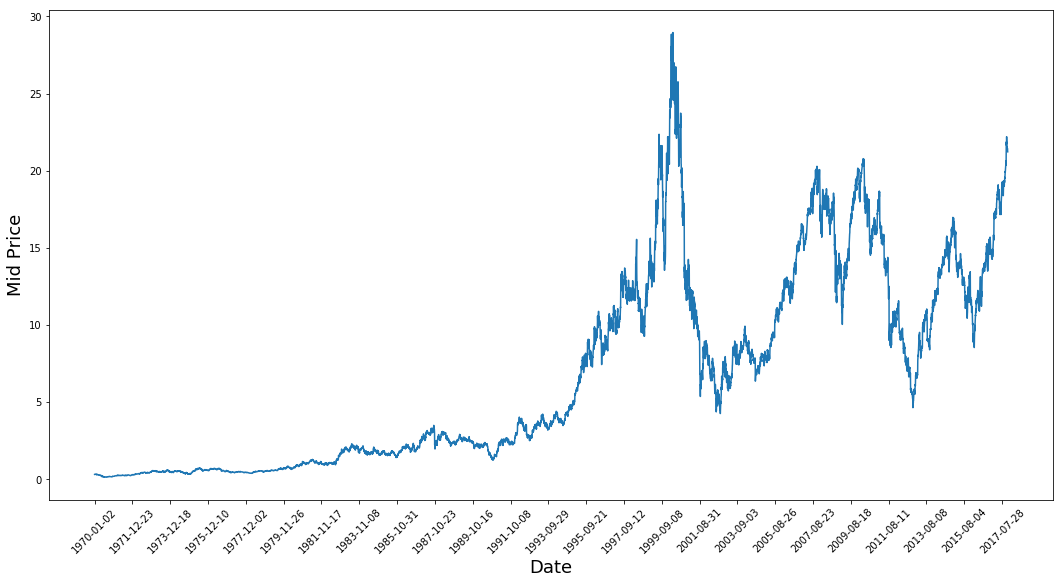

In [3]:
# the graph data is highly distributed
# prices were high during 2006 to 2008, after that it starts to decrease.

plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),(df['Low']+df['High'])/2.0)
plt.xticks(range(0,df.shape[0],500),df['Date'].loc[::500],rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.show()

In [4]:
df.shape

(12075, 5)

In [14]:
import sys
np.set_printoptions(threshold=sys.maxsize)
training_set = df.iloc[:, 1:2].values    # use open values to predict

In [6]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

In [31]:
# create data in 60 timesteps
X_train = []
y_train = []
for i in range(60, df.shape[0], 60):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
print(X_train.shape[0], X_train.shape[1], 1)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
print(X_train.shape)

201 60 1
(201, 60, 1)


In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.30, random_state=42)
print(y_test)

[0.60779655 0.0811121  0.1412778  0.44925132 0.23717182 0.01978922
 0.4842059  0.67554887 0.05844811 0.0665688  0.0684141  0.02423986
 0.26824751 0.00117702 0.00799744 0.21610321 0.57612859 0.39063991
 0.44264384 0.03289463 0.00392854 0.61779336 0.29943275 0.40063671
 0.7542566  0.01363023 0.19554129 0.34911208 0.19721883 0.29235624
 0.75025103 0.07089618 0.65079651 0.05635288 0.23193035 0.01087392
 0.03092265 0.01402394 0.44911438 0.11676166 0.05019047 0.05752717]


In [9]:
model = Sequential()

model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 50))
model.add(Dropout(0.2))

model.add(Dense(units = 1))

model.compile(optimizer = 'adam', loss = 'mean_squared_error')

model.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
140/140 [==============================] - 4s 30ms/step - loss: 0.0583
Epoch 2/100
140/140 [==============================] - 1s 10ms/step - loss: 0.0177
Epoch 3/100
140/140 [==============================] - 1s 10ms/step - loss: 0.0080
Epoch 4/100
140/140 [==============================] - 1s 10ms/step - loss: 0.0045
Epoch 5/100
140/140 [==============================] - 1s 10ms/step - loss: 0.0050
Epoch 6/100
140/140 [==============================] - 1s 9ms/step - loss: 0.0071
Epoch 7/100
140/140 [==============================] - 1s 9ms/step - loss: 0.0059
Epoch 8/100
140/140 [==============================] - 1s 9ms/step - loss: 0.0036
Epoch 9/100
140/140 [==============================] - 1s 10ms/step - loss: 0.0050
Epoch 10/100
140/140 [==============================] - 1s 9ms/step - loss: 0.0034
Epoch 11/100
140/140 [==============================] - 1s 10ms/step - loss: 0.0017
Epoch 12/100
140/140 [==============================] - 1s 9ms/step - loss: 0.0036
Epoch 

140/140 [==============================] - 1s 10ms/step - loss: 0.0011
Epoch 99/100
140/140 [==============================] - 1s 10ms/step - loss: 0.0014
Epoch 100/100
140/140 [==============================] - 2s 11ms/step - loss: 8.8314e-04


In [32]:
predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)
y_test = y_test.reshape(y_test.shape[0], 1)
real_stock_price = sc.inverse_transform(y_test)

# Plotting the Results

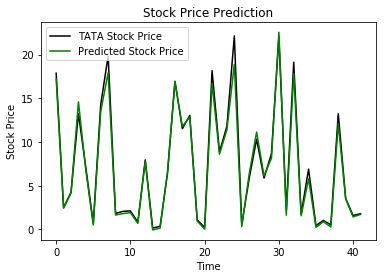

In [33]:
plt.plot(real_stock_price, color = 'black', label = 'TATA Stock Price')
plt.plot(predicted_stock_price, color = 'green', label = 'Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [ ]:
# as we can see it almost gives us true value for the stocks 